# Introduction to scETM

In this introductory tutorial, we will analyze a published mouse pancreas islet dataset (GSE84133).

### Load data
We use the AnnData package to load and write annotated data matrices in .h5ad files.

First, we check the dimension of input. Note that if clustering evaluation (e.g., calculating ARI) is desired, anndata.obs needs to have a cell_types column. If batch correction is desired, anndata.obs needs to have a batch_indices column.

In [29]:
import anndata as ad
import os
os.chdir('../')
adata = ad.read_h5ad('data/MousePancreas.h5ad')
print("Data matrix shape (n_obs x n_vars)", adata.shape)
print("Annotations: ", adata.obs.columns)

Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


Data matrix shape (n_obs x n_vars) (1886, 14878)
Annotations:  Index(['barcode', 'cell_types', 'cell_id', 'batch_indices'], dtype='object')


### Train scETM

In [30]:
!python train.py \
 --model scETM \
 --norm-cells \
 --batch-scaling \
 --h5ad-path data/MousePancreas.h5ad \
 --n-epochs 800 \
 --log-every 400 \
 --ckpt-dir results/ \
 --save-embeddings 

/Users/yifan/opt/anaconda3/envs/singlecell/lib/python3.8/site-packages/scvi/__init__.py:31: DeprecationWarning: scvi is deprecated, please uninstall scvi via `pip uninstall scvi` and install the new scvi-tools package at github.com/YosefLab/scvi-tools
  warnings.warn(deprecation_msg, DeprecationWarning)
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
INFO [2021-01-12 14:05:07,852]: argv: train.py --model scETM --norm-cells --batch-scaling --h5ad-path data/MousePancreas.h5ad --n-epochs 800 --log-every 400 --ckpt-dir results/ --save-embeddings
INFO [2021-01-12 14:05:07,852]: ckpt_dir: results/MousePancreas_scETM_batchScaling_normCells_time01_12-14_05_07
INFO [2021-01-12 14:05:07,852]: args: Namespace(anndata_path='', batch_scaling=True, batch_size=2000, ckpt_dir='results/MousePancreas_scETM_batchScaling_normCells_time01_12-14_05_07', clip=0, clustering_method='leiden', color_by=['cell_types', 'batch_indices'], dataset_str='MousePancreas', dpi_save=25

## Load scETM output embeddings

In [52]:
import pickle
with open('results/MousePancreas_scETM_batchScaling_normCells_time01_12-14_05_07/embeddings.pkl','rb') as f:
    emb = pickle.load(f)
rho = emb['rho'] # gene embeddings (gene by L)
delta = emb['delta'] # cell by topic
alpha = emb['alpha'] # topics embeddings (topic by L)
gene_names = emb['gene_names'] 

# store the cell embedding back in the anndata
adata.obsm['X_scETM'] = delta

## Leiden clustering

In [53]:
import scanpy as sc
#compute neighbors grouph
sc.pp.neighbors(adata, n_neighbors=15, use_rep='X_scETM')
# clustering
sc.tl.leiden(adata,resolution=0.03)

## Use scETM cell embedding for UMAP visualization

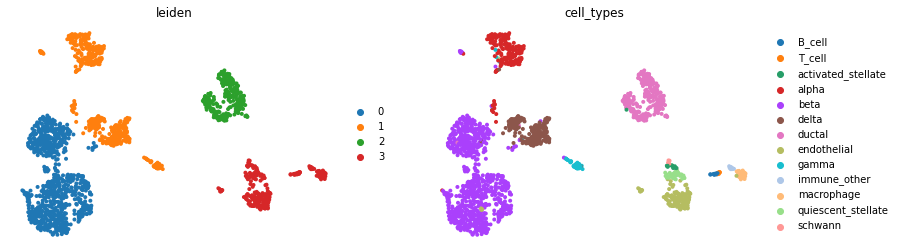

In [54]:
sc.tl.umap(adata)
fig = sc.pl.umap(adata, color=['leiden','cell_types'],
                 frameon=False, show=True, return_fig=True)

## Evaluation of clustering result using ARI and NMI

In [55]:
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score
ari = adjusted_rand_score(adata.obs.cell_types, adata.obs['leiden'])
nmi = normalized_mutual_info_score(adata.obs.cell_types, adata.obs['leiden'])
print('ARI', ari)
print('NMI', nmi)

ARI 0.848992461965599
NMI 0.8018756110144931
